## ***Question 1***

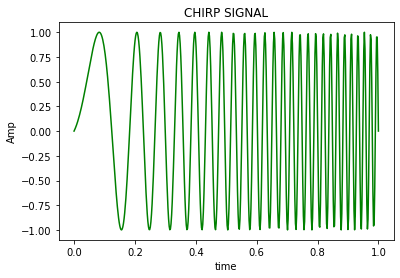

In [2]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from skimage.restoration import denoise_wavelet
##############CHIRP SIGNAL###########
f0 = 1        
fs = 500
n = np.linspace(0,1,fs)
k = 0.1*fs - f0       ### freq ranges from 1 Hz to 50 Hz
chirp = np.sin(2 * np.pi*(f0 +  k * n/2) * n)
plt.plot(n,chirp,'g')
plt.title('CHIRP SIGNAL')
plt.ylabel('Amp')
plt.xlabel('time')
plt.show()

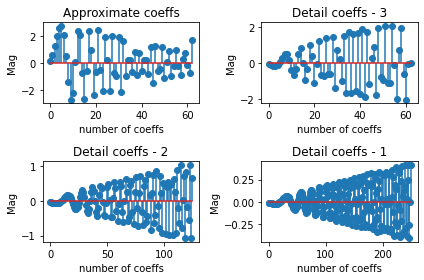

In [34]:
############# WAVELET TRANSFORM##########
coeff = pywt.wavedec(chirp,'haar',level = 3,mode = 'constant' )
cA3,cD3,cD2,cD1 = coeff
plt.subplot(221)
plt.stem(cA3,use_line_collection = True)
plt.title('Approximate coeffs')
plt.ylabel('Mag')
plt.xlabel('number of coeffs')
plt.subplot(222)
plt.stem(cD3,use_line_collection = True)
plt.title('Detail coeffs - 3')
plt.ylabel('Mag')
plt.xlabel('number of coeffs')
plt.subplot(223)
plt.stem(cD2,use_line_collection = True)
plt.title('Detail coeffs - 2')
plt.ylabel('Mag')
plt.xlabel('number of coeffs')
plt.subplot(224)
plt.stem(cD1,use_line_collection = True)
plt.title('Detail coeffs - 1')
plt.tight_layout()
plt.ylabel('Mag')
plt.xlabel('number of coeffs')
plt.tight_layout()
plt.show()

# ***QUESTION 2***

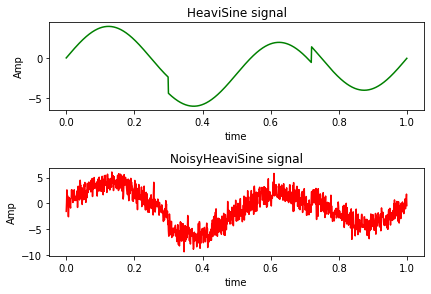

In [47]:
############## NOISE FILTERING#############
heavisine = pywt.data.demo_signal(name='HeaviSine',n = 1024)   #### Heavisine signal ### length of signal =1024
signalP = sum(heavisine**2)/len(heavisine)
n = np.arange(1024)/1024
SNR  = 15    ### db
NoiseP = signalP/(np.power(10,SNR/20))
plt.subplot(211)
plt.plot(n,heavisine,'g')
plt.title('HeaviSine signal')
plt.ylabel('Amp')
plt.xlabel('time')
Nzyheavisine = heavisine + np.random.normal(0,np.sqrt(NoiseP),1024)   
plt.subplot(212)
plt.plot(n,Nzyheavisine,'r')
plt.title('NoisyHeaviSine signal')
plt.tight_layout()
plt.ylabel('Amp')
plt.xlabel('time')
plt.show()

In [48]:
##########DEBYSHEV DECOMPOSTION LEVEL #########
cA3,cD3,cD2,cD1 = pywt.wavedec(Nzyheavisine,'db1',level = 3,mode = 'constant' )
sigma = np.sqrt(NoiseP)

In [50]:
#####THRESHOLD####
sigma = np.median(abs(np.array(list(cD3) + list(cD2) + list(cD1))))/0.6745
Thres = sigma * np.sqrt(2 * np.log(1024))
####HARD THRESHOLDING#########
def hardT(Thres,coeff):
    y = []
    for i in coeff:
        if -Thres <= i <=Thres :
            y.append(0)
        else:
            y.append(i)
    return np.array(y,dtype=object)
####SOFT THRESHOLDING#########
def softT(Thres,coeff):
    y = []
    for i in coeff:
        if -Thres < i <Thres :
            y.append(0)
        elif i > Thres:
            y.append(i - Thres)
        elif i < -Thres:
            y.append(i + Thres)
    return np.array(y,dtype=object)
### defining Snr function
def snr(s):
  s = sum(s**2) / len(s)
  y = 20 * np.log10((signalP/(s-signalP)))
  return y

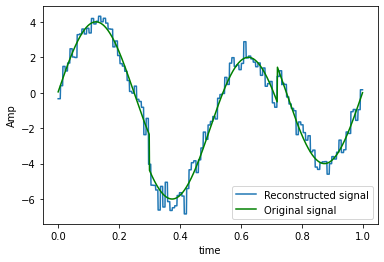

In [52]:
#thresholded coeffecients by soft thresholding
a1 = cA3
b1 = softT(thres(cD3),cD3)
c1 = softT(thres(cD2),cD2)
d1 = softT(thres(cD1),cD1)
coeffs2 = a1,b1,c1,d1
reconsoft = pywt.waverec(coeffs2,'db1',mode = 'constant')   ### Signal reconstruction 
plt.plot(n,reconsoft,label = 'Reconstructed signal')
plt.plot(n,heavisine,'g',label = 'Original signal')
plt.ylabel('Amp')
plt.xlabel('time')
plt.legend()
plt.show()

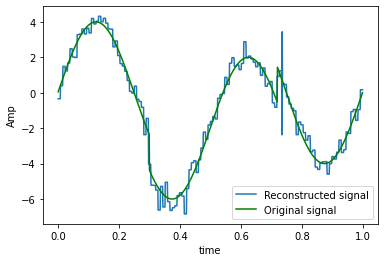

In [54]:
#thresholded coeffecients by hard thresholding
a1 = cA3
b1 = hardT(thres(cD3),cD3)
c1 = hardT(thres(cD2),cD2)
d1 = hardT(thres(cD1),cD1)
coeffs2 = a1,b1,c1,d1
reconhard = pywt.waverec(coeffs2,'db1',mode = 'constant')   ### Signal reconstruction 
plt.plot(n,reconhard,label = 'Reconstructed signal')
plt.plot(n,heavisine,'g',label = 'Original signal')
plt.ylabel('Amp')
plt.xlabel('time')
plt.legend()
plt.show()

In [55]:
print('SNR on hard thresholding :', snr(reconhard))
print('SNR on soft thresholding :', snr(reconsoft))

SNR on hard thresholding : 26.71965424070466
SNR on soft thresholding : 27.0522132264199


# ***Question 3***

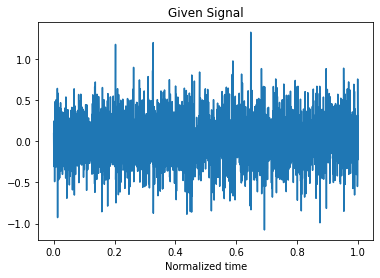

In [15]:
import pandas as pd
data = pd.read_csv('/content/sample_data/acc_00004.csv',header = None)
data = data.iloc[:,5]   ##### performing my exercise on the fourth column
data = (data - np.mean(data)/np.std(data))
n = len(data)
t = np.linspace(0,1,n)
plt.plot(t,data)
plt.title('Given Signal')
plt.xlabel('Normalized time')
plt.show()

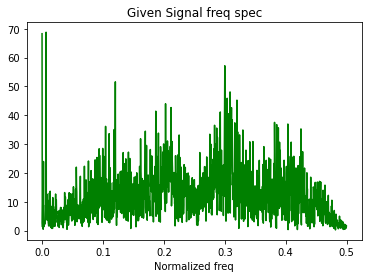

In [16]:
#### Frequency SPECTRUM
deconst = np.fft.fft(data)[:int(n*.5)]
f = np.arange(0,1,1/n)[:int(n*.5)]
plt.plot(f,abs(deconst),'g')
plt.title('Given Signal freq spec')
plt.xlabel('Normalized freq')
plt.show()

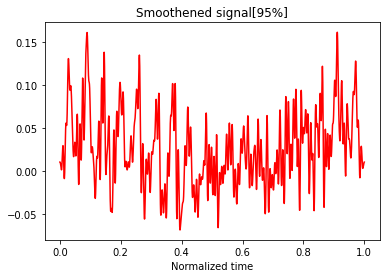

In [21]:
##### SMOOTHENING OF THE GIVEN SIGNAL
index = f < 0.05                    ##### zeroing the 95% of the high frequency components
smooth = deconst * np.array(index)
newcoeff = np.array(list(smooth) + list(reversed(smooth)))   #### new fft coefficients
smooth = np.fft.ifft(newcoeff)
plt.plot(t,np.real(smooth),'r')
plt.title('Smoothened signal[95%]')
plt.xlabel('Normalized time')
plt.show()

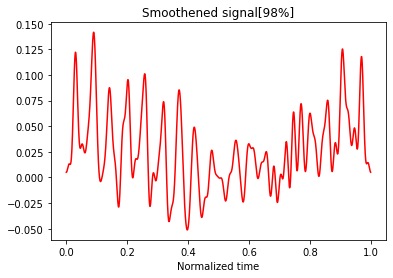

In [22]:
##### SMOOTHENING OF THE GIVEN SIGNAL
index = f < 0.02                    ##### zeroing the 98% of the high frequency components
smooth = deconst * np.array(index)
newcoeff = np.array(list(smooth) + list(reversed(smooth)))   #### new fft coefficients
smooth = np.fft.ifft(newcoeff)
plt.plot(t,np.real(smooth),'r')
plt.title('Smoothened signal[98%]')
plt.xlabel('Normalized time')
plt.show()

# ***MOVING AVERAGE***

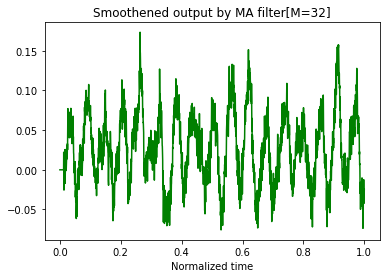

In [24]:
def movingavg(sgnl,m):
    y = np.empty([len(sgnl),])
    for i in range(len(sgnl)):
        if i >= m:
            y[i] = np.mean(sgnl[i-m : i])
        else:
            y[i] = 0
    return y
movingavgfiltering =  movingavg(data,32)   ####### 32 POINT MOVING AVERAGE FILTER

plt.plot(t,movingavgfiltering,'g')
plt.title('Smoothened output by MA filter[M=32]')
plt.xlabel('Normalized time')
plt.show()

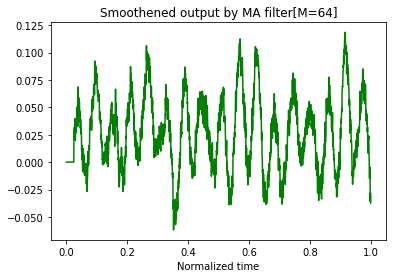

In [25]:
movingavgfiltering =  movingavg(data,64)   ####### 64 POINT MOVING AVERAGE FILTER
plt.plot(t,movingavgfiltering,'g')
plt.title('Smoothened output by MA filter[M=64]')
plt.xlabel('Normalized time')
plt.show()